04.03.2021
# Larger model (100K parameters) classification and error analysis

In [1]:
!pwd

/home/jovyan/LFI/bainbridge_2k/code


In [2]:
main_dir = '/home/jovyan/LFI/bainbridge_2k/'

# location of original labels: LFI/bainbridge_2k/meta
label_file = '../meta/labels2k_A_train.csv'

images_train_dir = '../images_train/'
images_test_dir = '../images_test/'

!ls $images_train_dir | wc -l 
!ls $images_test_dir | wc -l # both numbers should add to 2222 - 14 (doublettes) = 2208

# to build PATH to save the best model
model_dir = 'myModels/best/'

docume_dir = 'myModels/documentation/' # base directory, will get a subdir matching the model ( model.get_name() )

2108
100


In [3]:
'''# not necessary to run this - these requirements are already satisfied
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install torch
!pip install torchvision'''

'# not necessary to run this - these requirements are already satisfied\n!pip install numpy\n!pip install pandas\n!pip install matplotlib\n!pip install torch\n!pip install torchvision'

In [4]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler

import torchvision
from torchvision import transforms, utils

import PIL

In [5]:
# plt.rcParams['figure.figsize'] = (10, 5)

In [6]:
def set_all_seeds(s): 
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(s)

    # 2. Set `python` built-in pseudo-random generator at a fixed value
    import random
    random.seed(s)

    # 3. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(s)

    # 4. Set `pytorch` pseudo-random generator at a fixed value
    torch.manual_seed(s)

# define the model

In [7]:
from myModels import myModels as mm # mm = myModels
!pip install pytorch_model_summary
import pytorch_model_summary as pms

  Using cached pytorch_model_summary-0.1.2-py3-none-any.whl (9.3 kB)


In [8]:
model = mm.MyNeuralNetwork6()

imgH, imgW = model.get_img_shape() # get the required image size for the model
# to be used in the transform of the Dataset

# order of imgH, imgW might be off. I have quadratic images so I don't care
print(pms.summary(model, torch.zeros((1, 3, imgH, imgW)), show_input=True))

-------------------------------------------------------------------------
      Layer (type)           Input Shape         Param #     Tr. Param #
          Conv2d-1      [1, 3, 128, 128]             672             672
       MaxPool2d-2     [1, 24, 128, 128]               0               0
       Dropout2d-3       [1, 24, 63, 63]               0               0
          Conv2d-4       [1, 24, 63, 63]           5,208           5,208
       MaxPool2d-5       [1, 24, 63, 63]               0               0
       Dropout2d-6       [1, 24, 31, 31]               0               0
          Conv2d-7       [1, 24, 31, 31]           5,208           5,208
       MaxPool2d-8       [1, 24, 31, 31]               0               0
       Dropout2d-9       [1, 24, 15, 15]               0               0
         Linear-10             [1, 5400]          86,416          86,416
         Linear-11               [1, 16]              34              34
Total params: 97,538
Trainable params: 97,538
Non-

In [9]:
docume_dir_named = docume_dir+model.get_model_name()+'/'
print(model.get_model_name())
!ls $docume_dir

MyNeuralNetwork6
MyNeuralNetwork1-01  MyNeuralNetwork3-04		 MyNeuralNetwork6-02
MyNeuralNetwork3     MyNeuralNetwork3-05		 MyNeuralNetwork6-03
MyNeuralNetwork3-01  MyNeuralNetwork3_25training_epochs  MyNeuralNetwork6-04
MyNeuralNetwork3-02  MyNeuralNetwork6
MyNeuralNetwork3-03  MyNeuralNetwork6-01


if the directory already exist, it cannot be overwritten.

move the existing folder to a new name.

In [10]:
!mkdir $docume_dir_named

# Dataset and DataLoader for training (and val) set(s)

In [10]:
import A07tv as tv # train validate

In [11]:
df = pd.read_csv(label_file, index_col=0) 
df.index=range(df.shape[0])
setup = df[['Gender','Age','Race','newFilename']].copy()

# transform , no normalizing
transform = transforms.Compose([
    transforms.Resize((imgH,imgW)), # imgH, imgW as required for model
    transforms.ToTensor()
])

trainset = tv.TrainSet(setup=setup , transform=transform)

train_loader, val_loader = tv.loaders(trainset, setup) # batch_size=10, split=100 as defaults

In [12]:
len(val_loader.dataset) , len(train_loader.dataset)

(100, 2008)

## Train and validate

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ("torch.cuda.is_available(): ", torch.cuda.is_available())

torch.cuda.is_available():  True


In [14]:
from copy import deepcopy

## model setup
# variable model holds the model defined in first paragraph.
model = model.to(device) # pushing to device before passing it ti training() and validate() functions

learning_rate = 0.001
momentum = 0.9
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
criterion = nn.CrossEntropyLoss()

print('**', model)

num_epochs = 20 # 150 when things run smoothly
C=2 # number of classes
T=3 # loops for statistical evaluation

# ctl : classification timeline
# only 1 epoch, not a timeline really
ctl_epoch = np.zeros((len(val_loader.dataset),2), dtype=np.int16) # 2 for index and prediction
# a real timeline
ctl = np.zeros((*ctl_epoch.shape, num_epochs), dtype=np.int16) # added dimension for each epoch
# independent repetitions of training and validation loops , a timeline for each repetition
docume_ctl = np.zeros((T,*ctl.shape), dtype=np.int16) 

docume_error = np.zeros((T,C,num_epochs), dtype=np.int8)
docume_tvla = np.zeros((T,4,num_epochs))
docume_ge = np.zeros((T,2,7,C,num_epochs), dtype=np.int8) # 2: 0,1 pred, label different or not, 7: number of ethnicities
docume_f1 = np.zeros((T,num_epochs))

#docume_best_model = pd.DataFrame(columns=['t','epoch','val acc','state_dict'])
best_acc = 0.0

#good_seeds = [1,2,3,8,11,12] # for model 3 it happens that the model does not learn.
# we avoid these (bad) seeds.

for t in range(T):
    print('Repetition {}/{}'.format(t, T - 1))
    print('+' * 20)
    
    #seed_value = good_seeds[t]
    seed_value = t 
    set_all_seeds(seed_value)
    
    for name, module in model.named_children():
        if hasattr(module, 'reset_parameters'):
            #print('resetting ', name)
            module.reset_parameters()
    
    train_acc_history = []
    val_acc_history = []

    train_loss_history = []
    val_loss_history = []

    val_fn_history = []
    val_fp_history = []
    
    f1_history =[]

    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # train
        training_loss, training_acc = tv.training(model, train_loader, optimizer, criterion, device)
        train_loss_history.append(training_loss)
        train_acc_history.append(training_acc)

        # validation
        val_loss , val_cf_m , ctl_epoch, g_by_e, f1 = tv.validate(model, val_loader, criterion, device)
        # print('received from tv.validate : ' , ctl_epoch)
    
        if epoch==0:         
            g_by_e_hist = g_by_e[:,:,:].reshape((2,7,C,1))
            #print('epoch 0, g_by_e_hist :\n' , g_by_e_hist)
        else:
            g_by_e = g_by_e[:,:,:].reshape((2,7,2,1))
            g_by_e_hist = np.concatenate((g_by_e_hist, g_by_e), axis=3)
        
        val_loss_history.append(val_loss)
        
        tn, fp, fn, tp = val_cf_m.ravel()
        val_acc = (tp+tn)/len(val_loader.dataset)
        val_acc_history.append(val_acc)
       
        val_fn_history.append(fn)
        val_fp_history.append(fp)
        
        f1_history.append(f1)

        ctl[:,:,epoch]= ctl_epoch 
        
        # overall best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = deepcopy(model.state_dict())
            # docume_best_model just for surveillance. We only need best_model_wts
            # best_model_wts has length of 10, so I put it in a list. 
            # to extract it, use docume_best_model['state_dict'][0]
            # docume_best_model = docume_best_model.append(pd.DataFrame({'t':t,'epoch':epoch,'val acc':val_acc,'state_dict':[best_model_wts]}), ignore_index=True)
          
        ## end of train val epoch , go up to loop again or
    ## finish the train val epochs
    ## and document
        
    docume_error[t,0,:] = val_fn_history
    docume_error[t,1,:] = val_fp_history 
    
    docume_tvla[t,0,:] = train_loss_history # training, validation, loss and accuracy
    docume_tvla[t,1,:] = val_loss_history
    docume_tvla[t,2,:] = train_acc_history
    docume_tvla[t,3,:] = val_acc_history
    
    docume_ge[t,:,:,:] = g_by_e_hist
    
    docume_ctl[t:,:,:] = ctl
    
    docume_f1[t,:] = f1_history
    
    print(f'Best acc in validation: {best_acc:4f}')

# save the best model for final evaluation on test data
PATH = model_dir+'{}_acc{}.pt'.format(model.get_model_name(), int(10000*best_acc))
#PATH = model_dir+str(model.get_model_name())+'_acc'+str(int(10000*best_acc))+'.pt'
torch.save(best_model_wts, PATH )

** MyNeuralNetwork6(
  (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (conv2): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.25, inplace=False)
  (conv3): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=5400, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=2, bias=True)
)
Repetition 0/2
++++++++++++++++++++
Epoch 0/19
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.6

Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.5204 Acc: 0.7565

Validation Batch:    0 of 10
----------
validation Loss: 0.5335 Acc: 0.7500

Epoch 7/19
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.4929 Acc: 0.7729

Validation Batch:    0 of 10
----------
validation Loss: 0.5217 Acc: 0.7300

Epoch 8/19
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.4897 Acc: 0.7859

Validation Batch:    0 of 10
----------
validation Loss: 0.4970 Acc: 0.7700

Epoch 9/19
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.4553 

Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.3209 Acc: 0.8770

Validation Batch:    0 of 10
----------
validation Loss: 0.3309 Acc: 0.8500

Epoch 16/19
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.3113 Acc: 0.8775

Validation Batch:    0 of 10
----------
validation Loss: 0.2765 Acc: 0.8800

Epoch 17/19
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.3079 Acc: 0.8790

Validation Batch:    0 of 10
----------
validation Loss: 0.3118 Acc: 0.8400

Epoch 18/19
----------
Training Batch:    0 of 201
Training Batch:   50 of 201
Training Batch:  100 of 201
Training Batch:  150 of 201
Training Batch:  200 of 201
----------
Training Loss: 0.29

In [15]:
# what exactly do we get from the validation(...) call?
e,c,p,r,f = tv.validate(model, val_loader, criterion, device) 
# returns epoch_loss, cf_m, pred_dict, recall_by_e
print('epoch loss : ' , e ,'\n')
print('confusion matrix :\n ' , pd.DataFrame(c), '\n')
print('array of predictions:\n' , p,'\n')
print('recall by ethnicity, correct: \n' , pd.DataFrame(r[0,:,:]),'\n')
print('recall by ethnicity, misclassified: \n' , pd.DataFrame(r[1,:,:]))

Validation Batch:    0 of 10
----------
validation Loss: 0.2496 Acc: 0.9100

epoch loss :  0.24964121002703904 

confusion matrix :
      0   1
0  39   4
1   5  52 

array of predictions:
 [[ 777    0]
 [ 517    1]
 [1648    1]
 [ 249    1]
 [2070    0]
 [1151    1]
 [1873    0]
 [1289    1]
 [2010    0]
 [1938    1]
 [ 870    0]
 [1211    0]
 [ 255    1]
 [ 377    0]
 [1272    0]
 [ 216    1]
 [ 733    1]
 [ 303    0]
 [ 568    1]
 [1505    0]
 [1157    1]
 [2063    1]
 [1885    1]
 [ 176    1]
 [2022    1]
 [2005    1]
 [ 178    1]
 [1180    0]
 [2051    1]
 [ 313    1]
 [ 183    0]
 [1555    0]
 [1819    0]
 [ 394    1]
 [1859    1]
 [1246    1]
 [ 127    1]
 [1999    0]
 [1777    0]
 [1537    1]
 [ 349    1]
 [ 421    1]
 [ 415    0]
 [ 638    1]
 [2104    0]
 [ 563    1]
 [ 540    0]
 [ 770    1]
 [1056    0]
 [1698    0]
 [1287    1]
 [ 180    1]
 [1943    1]
 [ 600    1]
 [ 334    1]
 [1420    1]
 [ 507    0]
 [ 501    1]
 [ 825    1]
 [ 756    0]
 [2045    0]
 [1822    1]
 [ 78

note that values in the confusion matrix can be obtained from the later recall by ethnicity matrix.

Also check that this is correckt in this special case. the columns in the e matrix sum to the entries in the confusion matrix.

In [16]:
# docume_error documents the error for T trainings, over num_epochs for both (C=2) classes
print('shape : ' , docume_error.shape) # T, C, num_epochs
m1 = docume_error.mean(axis=2) # mean over the epochs
m2 = docume_error.mean(axis=2).mean(axis=0) # overall mean error for the classes
print(m1.shape , m2.shape)
print(m1)
print(m2)

shape :  (3, 2, 20)
(3, 2) (2,)
[[ 9.25 15.75]
 [ 6.65 14.5 ]
 [ 8.   15.55]]
[ 7.96666667 15.26666667]


# metrics
## loss and accuracy

Plot loss and accuracy for each repetition.

In [17]:
def plot_mat2d (mat_2d, set_title=None):
    if set_title is not None:
        assert type(set_title)==list, str(type(set_title))+' set_title should be a list of titles (str) for the subplots'
        assert len(set_title)==2 , 'need 2 titles for 2 subplots.'
    
    plt.figure(figsize=(12,4))
    
    plt.subplot(1, 2, 1)
    plt.plot(mat_2d[0,:], label='train loss')
    plt.plot(mat_2d[1,:], label='validation loss')
    plt.plot([0,num_epochs], [0.2,0.2], color='black', linewidth=0.7, linestyle = 'dotted')
    plt.xlabel('epoch')
    if set_title is None:
        plt.title('loss')
    else:
        plt.title(set_title[0])
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(mat_2d[2,:], label='train acc')
    plt.plot(mat_2d[3,:], label='validation acc')
    plt.plot([0,num_epochs], [0.9,0.9], color='black', linewidth=0.7, linestyle = 'dotted')
    plt.xlabel('epoch')
    if set_title is None:
        plt.title('accuracy')
    else:
        plt.title(set_title[1])
    plt.legend()
    plt.savefig(docume_dir_named+'loss_acc'+str(t)+'.png')
    plt.show()

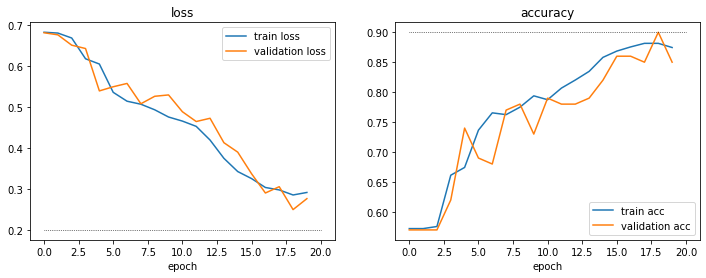

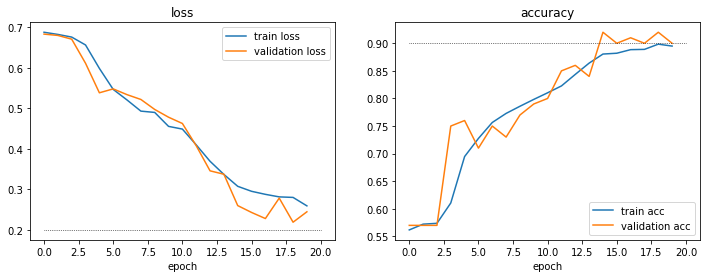

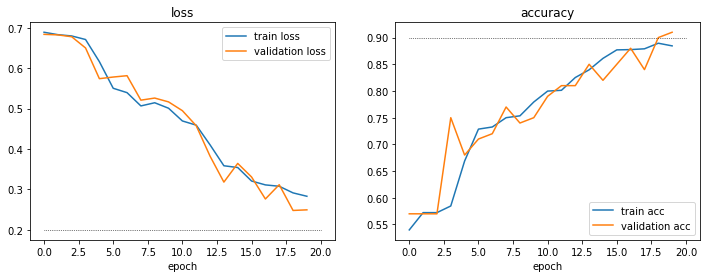

In [18]:
for t in range(T):
# for t in range(1,T-1):
    plot_mat2d(docume_tvla[t,:,:])

For T=5 the model did  not learn anything in 2 repetitions. The architecture completely failed 40% of the time!

For T=10 the model did not learn anything in 4 repetitions. The architecture completely failed 40% of the time!
That is bad but it can be avoided :-) by just starting again with another seed.

We continue to work with only the training validation loops / repetitions when the model did learn something.

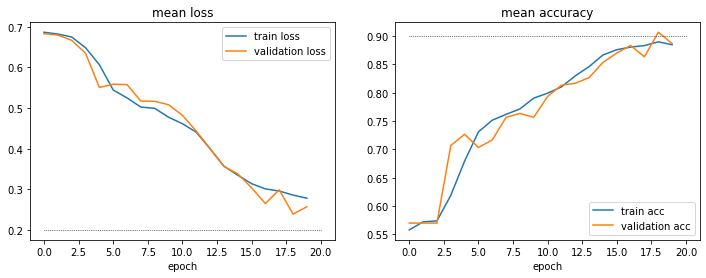

<Figure size 432x288 with 0 Axes>

In [20]:
plot_mat2d(docume_tvla.mean(axis=0), set_title=['mean loss', 'mean accuracy'])
plt.savefig(docume_dir_named+'loss_acc_mean.png')
plt.show()

## result from loss acc plots

### bias variance trade-off, early stopping

The mean of the training set accuracy (mean over the repetitions where the model actually does learn) rises to 90% after around 25 epochs, gets to almost 95% after 50 trining epochs. This indicates that the model can well differentiate b/w the given labels. There is no (heavy) bias problem.

The training loss continuously declines, which is good.

Since the validation (same mean as before) mean accuracy stays below 90% we have some variance remaining in our model / data set. The validation loss never reaches 0.2, it stops declining after about 30 epochs. 

The performance of this model is limited but not bad for my purpose.

The model should be trained around 25 to 30 epochs. After that overfitting starts.

In [1]:
est_early_stop_time = 35

### other stuff

The model from repetition t=2 gets the best validation results in acc and loss. However, this is probably due to a good match to the valation set. So it is a way of overfitting the validation set which will not help with the test set.

The mean accuracy tells me we can expect an accuracy on the test set of about 90%. Since the test set is itself random we would like to get a conf intervall. We could obtain this from the dev sets, maybe with more repetitions, i.e. a larger T.

Also it would be nice to have an automatic vis of the confInt...

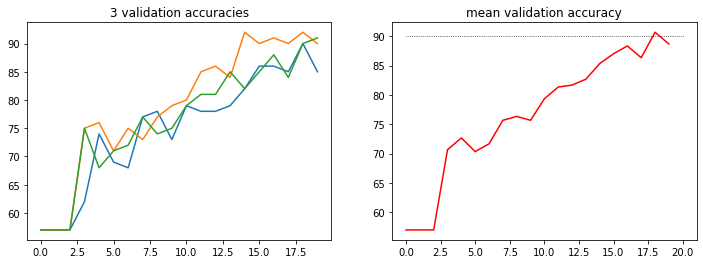

In [22]:
# for more than 3 lines (T>3) it is better to plot the mean in a separate coord system 
# accuracy timeline : 100 - misclassified = 100 - fp - fn
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot((100-docume_error.sum(axis=1)).T, label=range(2))
plt.title(str(docume_error.shape[0])+' validation accuracies')
plt.subplot(1,2,2)
plt.plot(np.mean((100-docume_error.sum(axis=1)).T,axis=1), label='mean', color='red')
plt.plot([0,num_epochs], [90,90], color='black', linewidth=0.7, linestyle = 'dotted')
plt.title('mean validation accuracy')

plt.savefig(docume_dir_named+'accuracies.png')
plt.show()

## f1 score, not weighted (anymore, changed it in tv.validate)
Since I don't really know what weighted means, I should not use it.

(3, 20)


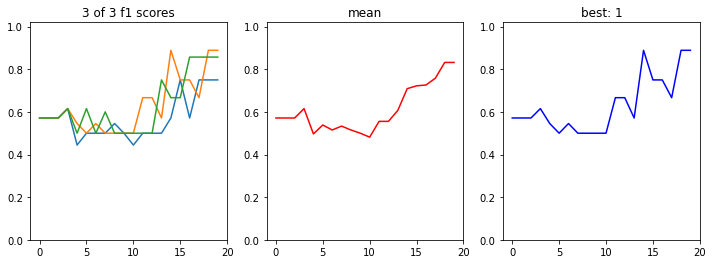

In [23]:
plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)
plt.plot(docume_f1.T)
plt.axis((-1,num_epochs,0,1.02))
plt.title(str(docume_error.shape[0])+' of '+str(T)+' f1 scores')
############################################
plt.subplot(1,3,2)
#plt.plot(docume_f1.T)
plt.plot(np.mean(docume_f1.T,axis=1), label='mean', color='red')
#plt.plot([0,num_epochs], [90,90], color='black', linewidth=0.7, linestyle = 'dotted')
plt.axis((-1,num_epochs,0,1.02))
plt.title('mean')
#############################################
plt.subplot(1,3,3)
print(docume_f1.shape)
#  print(np.argmax(docume_f1,axis=0))
best_in_rep = np.argmax(docume_f1,axis=1)
best = np.argmax([docume_f1[idx,best_in_rep[idx]] for idx in range(len(best_in_rep))])
#plt.plot(docume_f1.T)
plt.plot(docume_f1[best,:], color='blue')
plt.axis((-1,num_epochs,0,1.02))
#plt.plot([0,num_epochs], [90,90], color='black', linewidth=0.7, linestyle = 'dotted')
plt.title('best: '+str(best))
plt.savefig(docume_dir_named+'f1.png')
plt.show()



# error analysis by gender
with respect to the labeled genders. Up to now we looked into loss and accuracy for the train and dev set, ot differentiating b/w the labels of the images. Now we want to look into how each gender performs.

## Mean confusion matrix at estimated stopping epoch

In [24]:
cfm= pd.DataFrame([docume_ge[:,:,:,0,est_early_stop_time].mean(axis=0).sum(axis=1),
docume_ge[:,:,:,1,est_early_stop_time].mean(axis=0).sum(axis=1)[::-1]], columns=['classif f','classif m'], index=['label f','label m'])
cfm
# docume_ge[:,:,:,0,est_early_stop_time].mean(axis=0).sum(axis=1) # labeled female

,classif f,classif m
label f,33.333333,9.666667
label m,3.333333,53.666667


In [25]:
docume_f1[:,est_early_stop_time].mean()
#docume_f1.shape

0.7222222222222222

## error timeline by gender

In [26]:
def print_errors_by_label (docume):
    T = docume.shape[0]
    #print(plt.figure.params)
    if T < 4:
        plt.figure(figsize=(4*T,4))
    elif T <7:
        plt.figure(figsize=(4*(T//2+1),8))
    #eps = docume.shape[2] # num_epochs
    #T = docume.shape[0]
    # to set a uniform y axis, find the max value in 3rd for all t<=T and c<=C
    y_max = max(docume.max(axis=2).ravel())
    #print(y_max)
    
    for t in range(T):
        if T<4:
            plt.subplot(1, T, 1+t)
        elif T<7:
            plt.subplot(2, (T+1)//2, 1+t)
        plt.axis((-0.5,num_epochs,-0.5,y_max+0.5))
        plt.plot(docume[t,1,:], label='labeled female, fp')
        plt.plot(docume[t,0,:], label='labeled male, fn')
        plt.xlabel('epoch')
        #plt.ylabel('nr. missclassified')
        #plt.title('Types of missclassification')
        plt.legend()
    plt.savefig(docume_dir_named+'ctl_error.png')
# docume[t,0,0:num_epochs] = val_fn_history

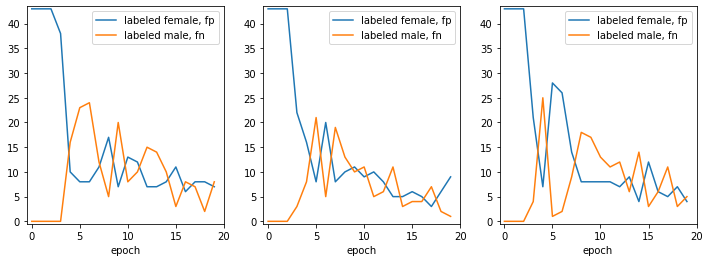

In [27]:
print_errors_by_label(docume_error)

In some runs, in absolute numbers the classification errors for labeled female and labeled male were about the same. This implies a higher proportion of missclassifications in females when compared to males.

But this is what will often happen when you go for few misclassifications. It basically does not matter whom you misclassify. Relative misclassification will always put the dominant class in the better position.

However, in this run (with seeds at 2 stages: when splitting into train/val sets and when running the training (important for random initilisation, say) labeled females were misclassified more often than males, though they amount for less than hals of the validation data. 

We have spotted an aspect of unfairness.

We should check that this is statistically significant.

How labeled females have a higher (absolute) error rate than males. This gets worse when we look into the relative error for the classes since there are more images labeled male in the data set (stratified split, so this holds for the training and validation set).

(2, 20)


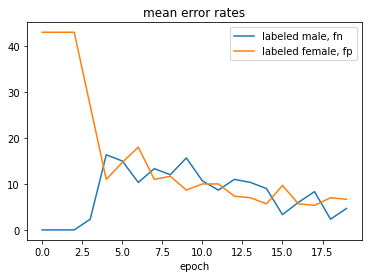

In [28]:
# errors for the classes , recall for labeled female and labeled male
ctl_mean = docume_error.mean(axis=0)
print(ctl_mean.shape)
plt.subplot(1, 1, 1)
plt.plot(ctl_mean.T)
plt.xlabel('epoch')
plt.legend(['labeled male, fn','labeled female, fp'])
plt.title('mean error rates')
plt.savefig(docume_dir_named+'ctl_error_mean.png')

We look at the error at the estimated stopping time. A box plot allows for easy observation of statistical significance (no test needed ...):

[[10  8]
 [ 3  5]
 [14  4]]


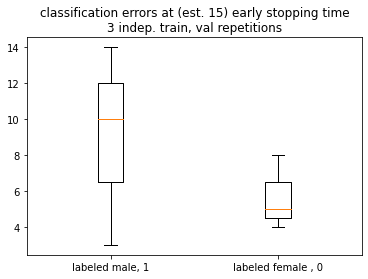

In [29]:
# data = docume_error[:,:,num_epochs-1] # error at final classification
data = docume_error[:,:,est_early_stop_time-1] # error at early stopping time
print(data)
fig, ax = plt.subplots()
ax.boxplot(data, labels=['labeled male, 1','labeled female , 0'])
#plt.legend(['fp','fn'])
plt.title('classification errors at (est. {}) early stopping time\n{} indep. train, val repetitions'.format(est_early_stop_time, data.shape[0]))
plt.savefig(docume_dir_named+'boxplot_error.png')
plt.show()

It should be noted that the disparity / difference b/w the genders gets more significant / gets worse / oscillates less as the model overfits the training data. This shows a clear trend.

Around the estimated early stopping time after 25 epochs, the boxplot shows a significant (as meets the eye, though I should have more independent repetitions) difference for the classification errors of ach gender group.

# error analysis by gender and ethnicity
during training we documented errors with respect to gender and ethnicity for the dev set. Now we want to look into how each gender and ethnicity combination performed.

[[33.         38.33333333  3.          8.66666667]
 [ 2.33333333  6.          1.66666667  0.        ]
 [ 1.          0.66666667  1.          0.33333333]
 [ 0.          0.          0.          0.        ]
 [ 1.          2.          0.          0.        ]
 [ 0.          1.          0.          0.        ]]
gender ethnicity documentation over epochs is reuced:
mean over repetitions, only estimated early stopping epoch.

6 sparcly populated ethnic categories

   f correct  m correct   f miscl   m miscl
0  33.000000  38.333333  3.000000  8.666667
1   2.333333   6.000000  1.666667  0.000000
2   1.000000   0.666667  1.000000  0.333333
3   0.000000   0.000000  0.000000  0.000000
4   1.000000   2.000000  0.000000  0.000000
5   0.000000   1.000000  0.000000  0.000000

add ethnic categories 2,3,4,5: 2 asian, 1 latin and 1 other category.
       f correct  m correct   f miscl   m miscl
white  33.000000  38.333333  3.000000  8.666667
black   2.333333   6.000000  1.666667  0.000000
other   2.000000

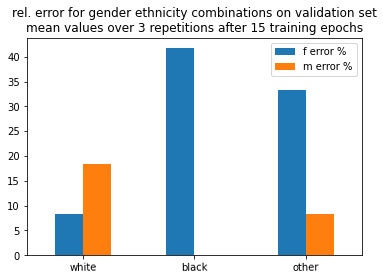

In [32]:
#print(docume_ge.shape)
a = docume_ge[:,:,:,:,est_early_stop_time-1].mean(axis=0) 

# data reduction: fixed epoch at estimated stopping time
# Check, if this is reproduced 
# or changed when changing the seeds for the repetitions

data = np.concatenate([a[0,1:,:], a[1,1:,:]], axis=1) # exclude ethnicity 0
print(data)
df= pd.DataFrame(data, index=range(6), columns=['f correct','m correct','f miscl','m miscl'])
print('gender ethnicity documentation over epochs is reuced:\nmean over repetitions, only estimated early stopping epoch.\n')
print('6 sparcly populated ethnic categories\n')
print(df)
print('\nadd ethnic categories 2,3,4,5: 2 asian, 1 latin and 1 other category.')

data= np.concatenate([data[0:2,:] , [np.sum(data[2:6,:],axis=0)]], axis=0)
#print(data)
#print('****')
df= pd.DataFrame(data, index=['white','black','other'], columns=['f correct','m correct','f miscl','m miscl'])
print(df)
print('\nadd column for totals and percentage')
df['f totals'] = df['f correct']+df['f miscl']
df['m totals'] = df['m correct']+df['m miscl']
df['f error %']= round(100*df['f miscl']/(df['f correct']+df['f miscl']),1)
df['m error %']= round(100*df['m miscl']/(df['m correct']+df['m miscl']),1)

# labels on x axis should be ['undef','white','black','other']
df[['f error %','m error %']].plot.bar(\
    rot = 1, \
    legend= True, \
    title='rel. error for gender ethnicity combinations on validation set\nmean values over {} repetitions after {} training epochs'.format(docume_ge.shape[0],est_early_stop_time))
#df#.plot.bar()
plt.savefig(docume_dir_named+'error_rates_grouped_by_ethnicity.png')